In [132]:
from keras.models import model_from_json, Model
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import csv
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

WEIGHTS_PATH = 'model_files/inceptionv3_clothing_classifier.h5'
JSON_MODEL = 'model_files/incep_filter_clothing_classifier.json'
#PRODUCT_FEATURES_FILE = 'products_features.tsv'
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
top_list = !ls data/train/tops
top_id = [int(x.split('.')[0]) for x in top_list]
top_id.sort()

In [133]:
def load_model(weights_path=WEIGHTS_PATH, json_path=JSON_MODEL):
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

In [134]:
def get_clothing_vector_model():
    loaded_model = load_model()
    loaded_model.layers.pop()  # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

In [135]:
model=get_clothing_vector_model()

Loaded model from disk


In [57]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [52]:
def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

In [ ]:
def process_data(id):
    out1 = []
    for i in id:
        print(i)
        name = 'data/train/tops/' + str(i) + '.jpg'
        im = image_preprocess(name)
        out = model.predict(im)
        out1.append(out[0])
    return out1

In [ ]:
list_names = !ls
if 'features_incep.csv' in list_names:
    df = pd.read_csv('features_incep.csv')
    num_start = df.shape[0]
else:
    num_start = 1
num_start

In [ ]:
val = 10

while num_start<=len(top_id):
# for i in range(shoe_num_start,shoe_num_start+val):#range(1,int(np.ceil(len(shoe_number)/val))):
    start = int(num_start)
    end = int(min(start+val,len(top_id)))
    print(start,end)
    try:
        out1 = process_data(top_id[start-1:end-1])
        res = pd.DataFrame(out1)
        res['product_id'] = pd.DataFrame(top_id[start-1:end-1])
        res.set_index('product_id', inplace=True)
    except:
        print('error image')
    
    if num_start==1:
        res.to_csv('features_incep.csv')
    else:
        with open('features_incep.csv', 'a') as f:
            res.to_csv(f, header = False)
    num_start+=val
    num_start = min(num_start,len(top_id))

In [34]:
cos_top=NearestNeighbors(n_neighbors=6,metric='cosine').fit(df)
distances_cos, indices_cos=cos_top.kneighbors(df)

In [35]:
Data_cos = pd.DataFrame(np.array(df.index[indices_cos]))

In [36]:
meta=pd.read_pickle('metadata/train_meta/tops.pickle')
meta=pd.DataFrame(meta)
meta['final_price']=0
meta.loc[meta['saleprice'] != None,'final_price']=meta['saleprice']
meta['final_price']=meta['final_price'].fillna(0)
meta.loc[meta['final_price'] == 0,'final_price']=meta['price']
meta.head()

,categories,id,image_url,parent_category,price,product_name,saleprice,final_price
0,[tees-and-tshirts],472140360,https://img.shopstyle-cdn.com/pim/4f/ad/4fadef...,tops,$19.50,Madewell Whisper Cotton V-Neck Pocket Tee,None,$19.50
1,[tees-and-tshirts],649091558,https://img.shopstyle-cdn.com/pim/c5/9f/c59f91...,tops,$17,BP. Raw Edge V-Neck Tee,None,$17
2,[tees-and-tshirts],668894662,https://img.shopstyle-cdn.com/pim/d7/1e/d71e87...,tops,$44,Sanctuary Uptown Tiered Hem Linen Tee,$26.40,$26.40
3,"[plus-size-tops, tees-and-tshirts]",666446889,https://img.shopstyle-cdn.com/pim/58/42/5842cb...,tops,$19.50,Madewell Whisper Cotton V-Neck Pocket Tee,None,$19.50
4,[womens-tops],660051520,https://img.shopstyle-cdn.com/pim/90/73/907359...,tops,$68,Free People Palisades Off the Shoulder Top,$45.56,$45.56


In [37]:
def find_price(img_id):
    price=meta.loc[meta['id']==img_id,'final_price'].values[0]
    return price

In [38]:
def plot_tops(indices):
    plt.figure(figsize=[10,10])

    plt.subplot(2,2,1)
    #im=mpimg.imread('data/test/tops/467117452.jpg')
    im = mpimg.imread('data/train/tops/'+str(Data_cos.iloc[indices].values.reshape(1,-1)[0][0])+'.jpg')
    plt.imshow(im)
    plt.title('Original - '+ find_price(Data_cos.iloc[indices].values.reshape(1,-1)[0][0]))
    #plt.title('Original - '+ find_price_test(467117452))
    plt.axis('off')

    plt.subplot(2,2,2)
    im = mpimg.imread('data/train/tops/'+str(Data_cos.iloc[indices].values.reshape(1,-1)[0][1])+'.jpg')
    #im = mpimg.imread('data/train/tops/'+str(df.index[indices[0]])+'.jpg')
    plt.imshow(im);
    plt.title('Recommendation 1 - '+ find_price(Data_cos.iloc[indices].values.reshape(1,-1)[0][1]))
    #plt.title('Recommendation 1 - '+ find_price(df.index[indices[0]]))
    plt.axis('off')

    plt.subplot(2,2,3)
    im = mpimg.imread('data/train/tops/'+str(Data_cos.iloc[indices].values.reshape(1,-1)[0][2])+'.jpg')
    plt.imshow(im);
    plt.title('Recommendation 2 - '+ find_price(Data_cos.iloc[indices].values.reshape(1,-1)[0][2]))
    plt.axis('off')

    plt.subplot(2,2,4)
    im = mpimg.imread('data/train/tops/'+str(Data_cos.iloc[indices].values.reshape(1,-1)[0][3])+'.jpg')
    plt.imshow(im);
    plt.title('Recommendation 3 - '+ find_price(Data_cos.iloc[indices].values.reshape(1,-1)[0][3]))
    plt.axis('off');

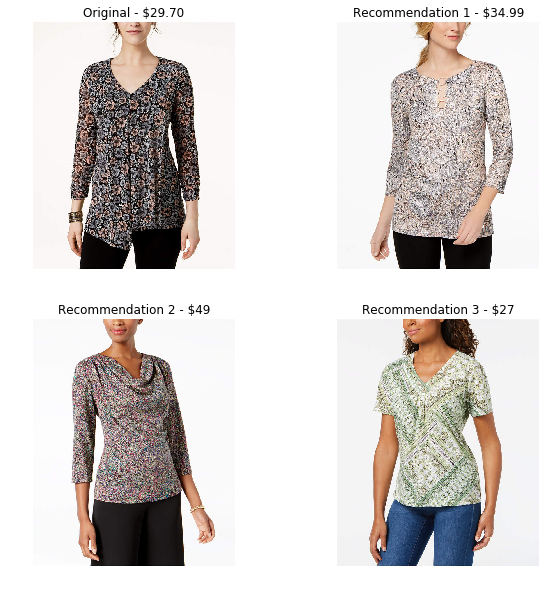

In [131]:
plot_tops(459)

In [48]:
meta_test=pd.read_pickle('metadata/test_meta/tops_test.pickle')
meta_test=pd.DataFrame(meta_test)
meta_test['final_price']=0
meta_test.loc[meta_test['saleprice'] != None,'final_price']=meta_test['saleprice']
meta_test['final_price']=meta_test['final_price'].fillna(0)
meta_test.loc[meta_test['final_price'] == 0,'final_price']=meta_test['price']
meta_test.head()

,categories,id,image_url,parent_category,price,product_name,saleprice,final_price
0,"[plus-size-tops, womens-tops]",692156409,https://img.shopstyle-cdn.com/pim/73/dc/73dc2d...,tops,$69,City Chic Plus Off-the-Shoulder Bell Sleeve Top,None,$69
1,[tees-and-tshirts],693359518,https://img.shopstyle-cdn.com/pim/26/a4/26a436...,tops,$156,Comme des Garcons PLAY Stripe Cotton Tee,None,$156
2,"[petite-tops, longsleeve-tops, tees-and-tshirts]",673521436,https://img.shopstyle-cdn.com/pim/ae/14/ae1480...,tops,$128,Eileen Fisher Silk Tee,$89.60,$89.60
3,"[sweaters, womens-tops]",651716636,https://img.shopstyle-cdn.com/pim/4a/9e/4a9e04...,tops,$130,Barefoot Dreams(R) Barefoot Dreams Cozychic Ul...,None,$130
4,[button-front-tops],734154784,https://img.shopstyle-cdn.com/pim/04/93/049353...,tops,$148,Rails Hunter Plaid Shirt,$88.80,$88.80


In [101]:
df_meta=pd.DataFrame()

In [97]:
category_list=!ls data/train

In [102]:
for i in category_list:
    meta=pd.read_pickle('metadata/train_meta/'+i+'.pickle')
    meta=pd.DataFrame(meta)
    meta['final_price']=meta['saleprice']
    meta['final_price']=meta['final_price'].fillna(0)
    meta.loc[meta['final_price'] == 0,'final_price']=meta['price']
    df_meta=pd.concat([df_meta,meta],ignore_index=True)

In [49]:
def find_price_test(img_id):
    price=meta_test.loc[meta_test['id']==img_id,'price'].values[0]
    return price

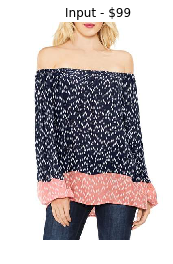

In [84]:
im = mpimg.imread('data/test/tops/693117809.jpg')
plt.imshow(im)
plt.axis('off')
plt.title('Input - '+ find_price_test(693117809));

In [89]:
a=image_preprocess('data/test/tops/699856879.jpg')
av = model.predict(a)

In [90]:
dist = cosine_distances(av, np.array(df))[0]
com=dict(zip(df.index,dist))
ids=sorted(com, key=com.get)
result=ids[:6]
result

[720615007, 726972372, 701955769, 722299575, 737985008, 628793494]

In [105]:
df_meta.head()

,categories,id,image_url,parent_category,price,product_name,saleprice,final_price
0,[day-dresses],642632776,https://img.shopstyle-cdn.com/pim/cc/00/cc0081...,dress,$128,Eliza J Belted Fit & Flare Dress,$76.80,$76.80
1,[evening-dresses],715586211,https://img.shopstyle-cdn.com/pim/e4/0a/e40a81...,dress,$179,Adrianna Papell Embellished Bodice Gown,$93.98,$93.98
2,[day-dresses],455310119,https://img.shopstyle-cdn.com/pim/34/a7/34a79f...,dress,$56,Leith Ruched Body-Con Tank Dress,None,$56
3,[cocktail-dresses],618768677,https://img.shopstyle-cdn.com/pim/96/c9/96c991...,dress,$149,Chelsea28 Asymmetrical Ruffle Shift Dress,$89.40,$89.40
4,[dresses],726468162,https://img.shopstyle-cdn.com/pim/1e/22/1e222d...,dress,$49.50,"Maison Jules Ruffled-Hem Striped A-Line Dress,...",$37.12,$37.12


In [113]:
def find_info(imgid):
    category=df_meta.loc[df_meta['id']==imgid,'parent_category'].values[0]
    img_path='data/train/'+category+'/'+str(imgid)+'.jpg'
    price=df_meta.loc[df_meta['id']==imgid,'final_price'].values[0]
    return [img_path,price]

In [115]:
find_info(715586211)

['data/train/dress/715586211.jpg', '$93.98']

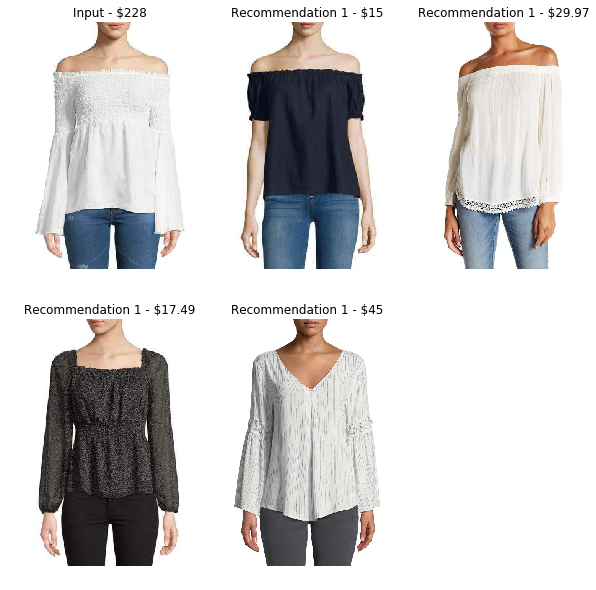

In [117]:
plt.figure(figsize=[10,10])

plt.subplot(2,3,1)
im = mpimg.imread('data/test/tops/699856879.jpg')
plt.imshow(im)
plt.axis('off')
plt.title('Input - '+ find_price_test(699856879))

plt.subplot(2,3,2)
info=find_info(result[0])
im = mpimg.imread(info[0])
plt.imshow(im)
plt.title('Recommendation 1 - '+ info[1])
plt.axis('off');

plt.subplot(2,3,3)
info=find_info(result[1])
im = mpimg.imread(info[0])
plt.imshow(im)
plt.title('Recommendation 1 - '+ info[1])
plt.axis('off');

plt.subplot(2,3,4)
info=find_info(result[2])
im = mpimg.imread(info[0])
plt.imshow(im)
plt.title('Recommendation 1 - '+ info[1])
plt.axis('off');



plt.subplot(2,3,5)
info=find_info(result[3])
im = mpimg.imread(info[0])
plt.imshow(im)
plt.title('Recommendation 1 - '+ info[1])
plt.axis('off');
